# Pre-processing

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)

## Explore our dataset

In [35]:
df = pd.read_csv("dataset\ADNI_coef_lm.csv")
# remove IDs columns
df.drop(['Unnamed: 0','Age','GenderMale','yEdu'],axis=1,inplace=True)
df.rename(columns = {'(Intercept)':'Intercept'}, inplace = True)
print(df.shape)
print(df.head())

(740, 3)
   Intercept  variable_num   RID
0  86.232097      0.337242   751
1  88.573186      0.318934   934
2  89.513067      0.316281  1408
3  87.767324      0.316272  2208
4  87.991367      0.309213    69
     Intercept  variable_num  RID
552  77.449713      -0.34106    4


In [30]:
#check dataset statistics
df.describe()

,Intercept,variable_num,RID
count,740.000000,740.000000,740.000000
mean,83.022119,-0.161119,2169.617568
std,8.586054,0.282038,1813.869791
min,58.988369,-1.038656,2.000000
25%,77.566760,-0.342697,566.750000
50%,84.201929,-0.124632,1283.000000
75%,90.080545,0.070164,4295.500000
max,99.392742,0.337242,5289.000000


C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

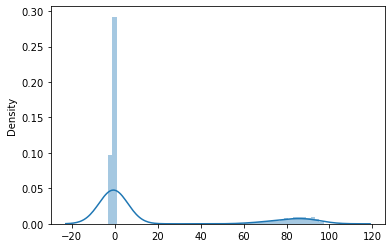

In [15]:
#check dataset distribution
sns.distplot(data)

Why negative values ? Because data has already been log-normalized -> low intensities of a protein are negative.

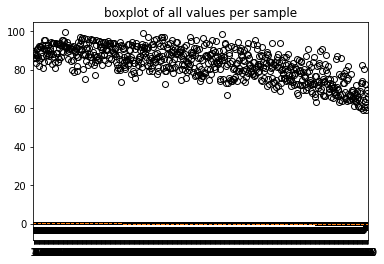

In [16]:
#plot each sample boxplot
plt.boxplot(data.transpose())
plt.title('boxplot of all values per sample')
plt.show()

Distribution of dataset does not seem to be nicely normally distributed -> need to be normalized

## Normalization

In [17]:
#normally test function -> check if each column is normally distr
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    count=0
    for i in p:
        if i > alpha:  # null hypothesis: x comes from a normal distribution
            count+=1
    print('There are ',count,'normally distributed features out of',data.shape[1])

### Quantile Normalization

From other paper:\
The quantile technique was the most unique in that an iterative process was not required for normalization. Additionally, this normalization technique does not force the means of replicate samples to converge upon a predetermined value, as was observed in the case of the other three normalization techniques (i.e., central tendency, linear regression, and local regression), where the mean of relative peptide abundances were forced to converge to zero. When the quantile technique was applied to our data, the mean of the common distribution following normalization fell within the range of means for the compared runs. This observation has an important implication related to the selection of a normalization technique and to the number of peptides common to all replicates runs used in the normalization process. Since we opted to perform central tendency, linear regression, and local regression normalization on a global scale, where measured abundances of all common peptides are used, we assumed that the leverage of peptide ratios containing biological variability on the mean relative abundance of the set of peptide ratios would not be significant. Such an assumption is commonly made for mRNA expression analysis where arrays are designed to target a large or complete set of open reading frames 21. In the case of high-throughput proteomics large number of peptides can be detected, but peptides can fail to be detected for many reasons (changes in the LC separation, the overshadowing of less abundant peptides by highly abundant peptides in the same spectrum, variations in MS performance, etc.) 3, 10. Hence, the mean relative abundance of replicate sets of peptide ratios may indeed lie above or below zero. In such a case, quantile normalization would be more suitable for reducing variability among these replicate runs.

In [18]:
#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0),index=df.index,columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# compute quantile normalized data
df_qn=quantile_normalize(data)
data = df_qn
norm_test(data)

There are  0 normally distributed features out of 5


### Box-cox transformation

Data must be positive !

The objective is to obtain a normal distribution of the transformed data (after transformation) and a constant variance.

If a logarithmic transformation is applied to this distribution, the differences between smaller values will be expanded (because the slope of the logarithmic function is steeper when values are small) whereas the differences between larger values will be reduced (because of the very moderate slope of the log distribution for larger values). If you inflate differences on the left tail and reduce differences on the right side tail, the result will be a symmetrical normal distribution, and a variance that is now constant (whatever the mean).

In [19]:
#compute box-cox transformation
df_bc = pd.DataFrame().reindex_like(data)

for col in df_qn:
    df_bc[col],_ = stats.boxcox(df_qn[col])
data = df_qn
norm_test(data)

ValueError: Data must not be constant.

In [ ]:
#check if data is better normally distributed
sns.distplot(data)

## Split dataset

In [ ]:
data['binary_class'] = df['binary_class']
data['three_class'] = df['three_class']
X = data.drop(columns = ['binary_class','three_class'])
y = data["three_class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 97)

## Export dataset

In [ ]:
#export to csv file
X_train.to_csv(r'dataset\X_train_3.csv')
X_test.to_csv(r'dataset\X_test_3.csv')
y_train.to_csv(r'dataset\y_train_3.csv')
y_test.to_csv(r'dataset\y_test_3.csv')